In [14]:
import numpy as np
import shapely
import cartopy
import proplot as plot
import pyart
import pandas as pd
import geopandas as gpd
import os
from tqdm import tqdm
import leroi
import sys
sys.path.append("/home/564/jb2354/dev/climo")
from archive_tools import get_australia_land_coast
sys.path.append('/home/564/jb2354/dev/UQXPOL/notebooks/')
from xpol import *
mainland, coast = get_australia_land_coast('/home/564/jb2354/.local/share/cartopy/shapefiles/natural_earth/physical/ne_10m_admin_0_countries.shp')

In [20]:
# radar position
position = (-27.802222, 153.020278)
rpoint = shapely.geometry.Point(position[::-1])
aeqd = cartopy.crs.AzimuthalEquidistant(central_longitude=position[1], central_latitude=position[0])

In [40]:
dirr = '/scratch/kl02/kt6138/tmp/Xpol/actual_data'
volumes = get_volumes_from_dir(dirr, start = pd.to_datetime('2023-09-28 02:00:00'), end = pd.to_datetime('2023-09-28 04:30:00'))

for files in tqdm(volumes[:]):
    radar = scans_to_volume(files, position = position, azimuth = 100)
    fn = 'xpol_' + '_'.join(files[0].split('/')[-1].split('_')[slice(1,3)])+'_vol.nc'
    pyart.io.write_cfradial('/scratch/kl02/jb2354/xpol/processed/' + fn, radar)

100%|██████████| 44/44 [16:42<00:00, 22.79s/it]


### Plot

In [5]:
radar = pyart.io.read('/scratch/kl02/jb2354/xpol/processed/xpol_20230928_025000_vol.nc')
radar.add_field('SNR', pyart.retrieve.calculate_snr_from_reflectivity(radar, refl_field = 'DBZH'))
radar.fields['DBZH']['data'] = np.ma.masked_array(radar.fields['DBZH']['data'], radar.fields['SNR']['data'] < 2)
radar = leroi.mask_invalid_data(radar, 'DBZH', add_to=['DBZH', 'VRADH', 'RHOHV', 'ZDR', 'KDP'], min_field=-np.inf, min_area = 50) 

In [27]:
radar2 = pyart.aux_io.read_odim_h5('/scratch/kl02/jb2354/winds/66/66_20230928_025000.pvol.h5', file_field_names=True)
aeqd2 = cartopy.crs.AzimuthalEquidistant(central_longitude=radar2.longitude['data'][0], central_latitude=radar2.latitude['data'][0])
rpoint2 = shapely.geometry.Point((radar2.longitude['data'][0], radar2.latitude['data'][0]))
radar2 = leroi.mask_invalid_data(radar2, 'DBZH', add_to=['DBZH', 'VRADH', 'RHOHV', 'ZDR', 'KDP'], min_field=0, min_area = 50) 

In [21]:
rpoints = gpd.GeoSeries([rpoint, rpoint2], crs = 'epsg:4326')

In [46]:
print(radar.fixed_angle['data'], radar2.fixed_angle['data'])

[ 1.5  2.5  3.5  4.5  5.5  7.   9.  11.  15.  20.  25.  30.  35. ] [90.  32.  23.  17.  13.  10.   7.8  6.   4.7  3.5  2.4  1.4  0.8  0.5]


/home/564/jb2354/miniforge3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/564/jb2354/miniforge3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/564/jb2354/miniforge3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/564/jb2354/miniforge3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.w

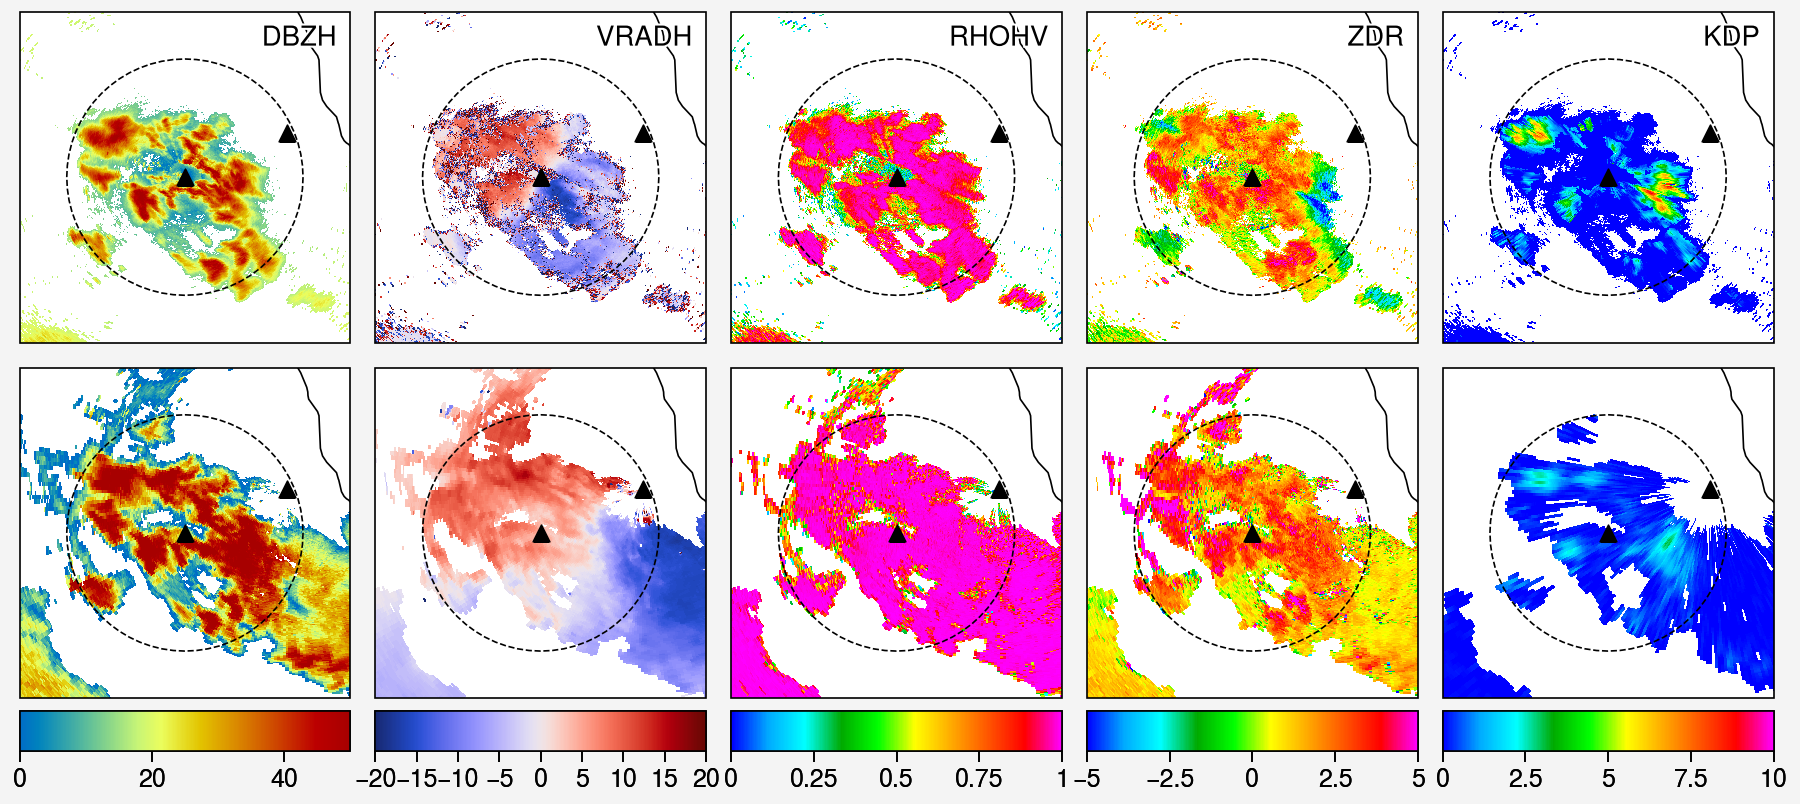

In [38]:
kwargs = {'DBZH': dict(vmin = 0, vmax = 50, cmap = 'pyart_homeyerrainbow', discrete = False, edgecolor = 'none'),
          'VRADH': dict(vmin = -20, vmax = 20, cmap = 'BR', discrete = False, edgecolor = 'none'),
          'RHOHV': dict(vmin = 0, vmax = 1, cmap = 'pyart_refdiff', discrete = False, edgecolor = 'none'),
          'ZDR': dict(vmin = -5, vmax = 5, cmap = 'pyart_refdiff', discrete = False, edgecolor = 'none'),
          'KDP': dict(vmin = 0, vmax = 10, cmap = 'pyart_refdiff', discrete = False, edgecolor = 'none'),
          'WRADH': dict(vmin = 0, vmax = 4, cmap = 'pyart_refdiff', discrete = False, edgecolor = 'none'),
          'SNR': dict(vmin = 2, vmax = 5, cmap = 'pyart_refdiff', discrete = False, edgecolor = 'none'),
         }


tilt, tilt2, fields = 2, 12, ['DBZH', 'VRADH', 'RHOHV', 'ZDR', 'KDP']


xr, yr, zr = radar.get_gate_x_y_z(tilt)
xr2, yr2, zr2 = radar2.get_gate_x_y_z(tilt2)

rmask = ((radar.get_field(tilt, 'SNR') < 2))

N = len(fields)
fig, axs = plot.subplots(ncols = N, nrows = 2, width = 9, wspace = 1, proj = aeqd)

lim = 3.5e4
for ax in axs:
    ax.set_extent(np.array([-1,1,-1,1])*lim, crs = aeqd)
    #coast.to_crs(aeqd).plot(ax = ax, ec = 'none', fc = 'powder blue')
    #mainland.to_crs(aeqd).plot(ax = ax, ec=  'none', fc= 'bisque')
    mainland.to_crs(aeqd).plot(ax = ax, ec=  'k', fc= 'none', zorder = 3)
    rpoints.plot(ax = ax, fc = 'k', marker = '^', zorder = 3)
    rpoints.iloc[0:1].to_crs(aeqd).buffer(25000).plot(ax = ax, fc= 'none', ec = 'k', ls = '--', zorder = 3)


for i, field in enumerate(fields):

    axs[i].format(title = field, titleloc = 'ur')
    rfield = np.ma.masked_array(radar.get_field(tilt, field), rmask)
    axs[i].pcolormesh(xr, yr, rfield, transform = aeqd, **kwargs[field])

    rfield = radar2.get_field(tilt2, field)
    axs[i+N].pcolormesh(xr2, yr2, rfield, colorbar = 'b', colorbar_kw = dict(length = 1), transform = aeqd2, **kwargs[field])

fig.save('/g/data/kl02/jb2354/UQXPOL/mtstap_comparison.png', dpi = 200)
plot.show()

<AxesSubplot:>

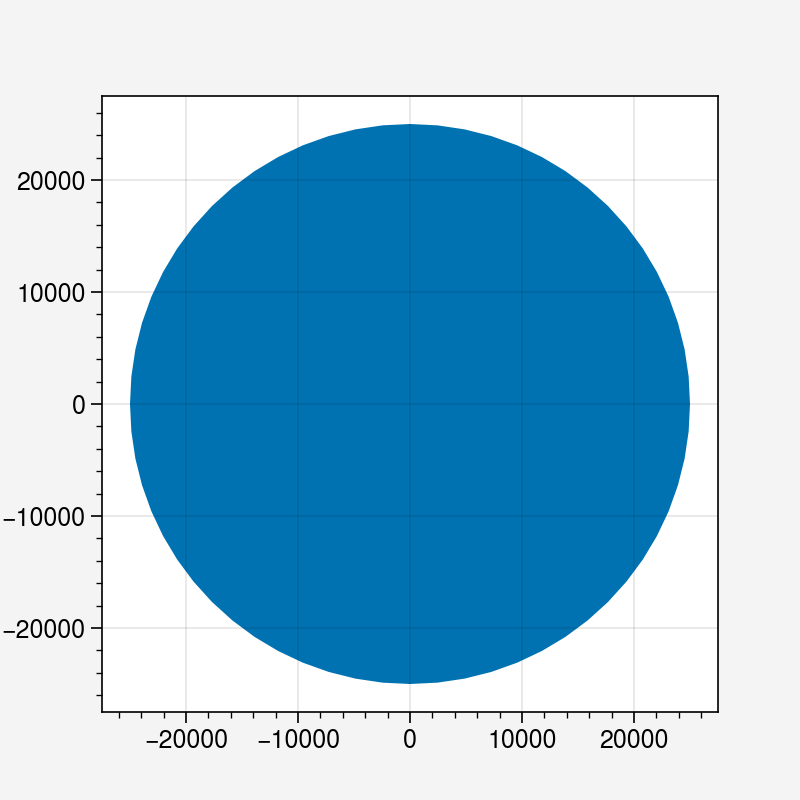